In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prim
import seaborn as sns
from sklearn import mixture
import os
from clustering_and_prim_tools import *

In [4]:
%matplotlib inline

In [5]:
myfolder = "C:/Users/WB451855/OneDrive - WBG/!infra_needs_data/coastal_protection_output_data/"

In [8]:
mydata = pd.read_csv(myfolder+"global_output_cumulative.csv")

In [10]:
mydata.sample(3)

,locationid,locationname,rcp,ada,ssp,adacost,riverprotection,time,par,pop_below_h100,seafloodcost,riverdike_cost,riverdike_maintenance_cost,seadike_cost,seadike_maintenance_cost,surge_barrier_cost,surge_barrier_maintenance_cost,protection_investment_cost,protection_maintenance_cost
1309,GLOBAL_000,GLOBAL feature generated automatically,RCP 8.5 (High ice melting),Constant Protection Levels,SSP2,Low Adaptation Unit Cost,Only dikes,2031-2050,160067.0100,1019036.00,2021655.000,4345.1110,4047.392,56136.50,121134.510,0.0000,0.0000,60481.6110,125181.9020
1208,GLOBAL_000,GLOBAL feature generated automatically,RCP 8.5 (High ice melting),CBA Protection Levels,SSP2,Low Adaptation Unit Cost,CBA River Protection,2031-2050,4758.1455,994623.30,67888.500,697.8418,1240.196,37435.06,148900.975,2327.6538,3285.1735,40460.5556,153426.3445
677,GLOBAL_000,GLOBAL feature generated automatically,RCP 8.5 (High ice melting),Risk intolerance,SSP2,High Adaptation Unit Cost,Only dikes,2015-2030,76383.2100,897841.65,143913.065,11513.6290,11257.638,178997.07,336540.100,0.0000,0.0000,190510.6990,347797.7380


In [14]:
mydata.rcp.unique()

array(['RCP 2.6 (Low ice melting)', 'RCP 4.5 (Medium ice melting)',
       'RCP 8.5 (High ice melting)'], dtype=object)

In [18]:
mydata.riverprotection.unique()

array(['CBA River Protection', 'Only dikes'], dtype=object)

In [36]:
rcp_dict = dict({'RCP 2.6 (Low ice melting)':0, 'RCP 4.5 (Medium ice melting)':1,
       'RCP 8.5 (High ice melting)':2})
ada_dict = dict({'CBA Protection Levels':0, 'Constant Abs. Flood Risk':1,
       'Constant Protection Levels':2, 'Constant Rel. Flood Risk':3,
       'Risk intolerance':4})
ssp_dict = dict({'SSP2':0, 'SSP3':1, 'SSP5':2})
adacost_dict = dict({'High Adaptation Unit Cost':1, 'Low Adaptation Unit Cost':0})

In [37]:
mydata["rcp_num"] = mydata.rcp.replace(rcp_dict)
mydata["ada_num"] = mydata.ada.replace(ada_dict)
mydata["ssp_num"] = mydata.ssp.replace(ssp_dict)
mydata["adacost_num"] = mydata.adacost.replace(adacost_dict)

In [24]:
sns.set_context("poster",rc={"font.size": 28})
sns.set_style("whitegrid")

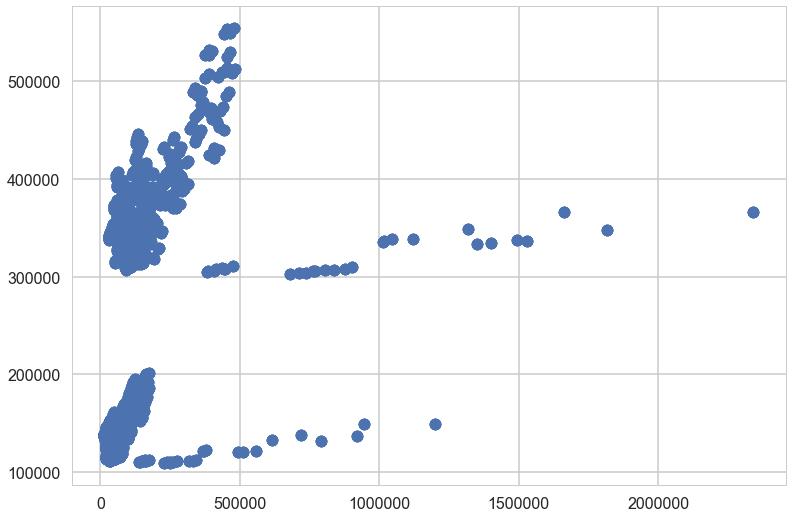

In [25]:
plt.scatter(mydata.protection_investment_cost,mydata.protection_maintenance_cost)

In [59]:
mydata.time.unique()

array(['2015-2030', '2031-2050', '2051-2100'], dtype=object)

In [84]:
mydata_2100 = mydata[mydata.time=='2015-2030'].reset_index()

In [85]:
mydata_2100

,index,locationid,locationname,rcp,ada,ssp,adacost,riverprotection,time,par,...,seadike_cost,seadike_maintenance_cost,surge_barrier_cost,surge_barrier_maintenance_cost,protection_investment_cost,protection_maintenance_cost,rcp_num,ada_num,ssp_num,adacost_num
0,0,GLOBAL_000,GLOBAL feature generated automatically,RCP 2.6 (Low ice melting),CBA Protection Levels,SSP2,High Adaptation Unit Cost,CBA River Protection,2015-2030,7540.96250,...,988492.5000,326042.050,478273.32000,4786.58235,1.528488e+06,336886.87985,0,0,0,1
1,1,GLOBAL_000,GLOBAL feature generated automatically,RCP 2.6 (Low ice melting),CBA Protection Levels,SSP2,High Adaptation Unit Cost,CBA River Protection,2015-2030,8796.66250,...,32786.9580,327607.850,797.76690,4794.56850,3.553180e+04,338509.34300,0,0,0,1
2,2,GLOBAL_000,GLOBAL feature generated automatically,RCP 2.6 (Low ice melting),CBA Protection Levels,SSP2,High Adaptation Unit Cost,CBA River Protection,2015-2030,10138.22100,...,38064.6650,329467.950,862.12175,4803.19975,4.103113e+04,340430.68425,0,0,0,1
3,3,GLOBAL_000,GLOBAL feature generated automatically,RCP 2.6 (Low ice melting),CBA Protection Levels,SSP2,High Adaptation Unit Cost,CBA River Protection,2015-2030,11422.61600,...,37085.6470,330600.550,833.88625,4811.54850,3.996854e+04,341622.85650,0,0,0,1
4,4,GLOBAL_000,GLOBAL feature generated automatically,RCP 2.6 (Low ice melting),CBA Protection Levels,SSP2,High Adaptation Unit Cost,Only dikes,2015-2030,7540.96250,...,988492.5000,326042.050,0.00000,0.00000,1.121772e+06,338226.59350,0,0,0,1
5,5,GLOBAL_000,GLOBAL feature generated automatically,RCP 2.6 (Low ice melting),CBA Protection Levels,SSP2,High Adaptation Unit Cost,Only dikes,2015-2030,8796.66250,...,32786.9580,327607.850,0.00000,0.00000,3.654315e+04,339886.29850,0,0,0,1
6,6,GLOBAL_000,GLOBAL feature generated automatically,RCP 2.6 (Low ice melting),CBA Protection Levels,SSP2,High Adaptation Unit Cost,Only dikes,2015-2030,10138.22100,...,38064.6650,329467.950,0.00000,0.00000,4.211105e+04,341847.56300,0,0,0,1
7,7,GLOBAL_000,GLOBAL feature generated automatically,RCP 2.6 (Low ice melting),CBA Protection Levels,SSP2,High Adaptation Unit Cost,Only dikes,2015-2030,11422.61600,...,37085.6470,330600.550,0.00000,0.00000,4.102356e+04,343078.60300,0,0,0,1
8,8,GLOBAL_000,GLOBAL feature generated automatically,RCP 2.6 (Low ice melting),CBA Protection Levels,SSP2,Low Adaptation Unit Cost,CBA River Protection,2015-2030,4558.32825,...,556113.3200,128213.125,225164.76500,2252.52650,7.924424e+05,131936.37215,0,0,0,0
9,9,GLOBAL_000,GLOBAL feature generated automatically,RCP 2.6 (Low ice melting),CBA Protection Levels,SSP2,Low Adaptation Unit Cost,CBA River Protection,2015-2030,5249.54150,...,15297.8950,128951.190,1443.08730,2311.53810,1.719976e+04,132703.12010,0,0,0,0


In [86]:
oois = ['protection_investment_cost','protection_maintenance_cost']

data = np.array([[mydata_2100[oois[0]][0],mydata_2100[oois[1]][0]]])
for i in range(1,len(mydata_2100.index)):
    data = np.concatenate((data,np.array([[mydata_2100[oois[0]][i],mydata_2100[oois[1]][i]]])))

data_norm = normalize(data)

In [87]:
inputs = mydata[["rcp_num","ada_num","ssp_num","adacost_num"]]

In [88]:
n_clusters = 4
f_value = 0.5
seuil = 1.2

In [89]:
dummy = get_prim(n_clusters, f_value, data,oois[0],oois[1],inputs,data_norm)
boxes = dummy[0]
df = dummy[1]

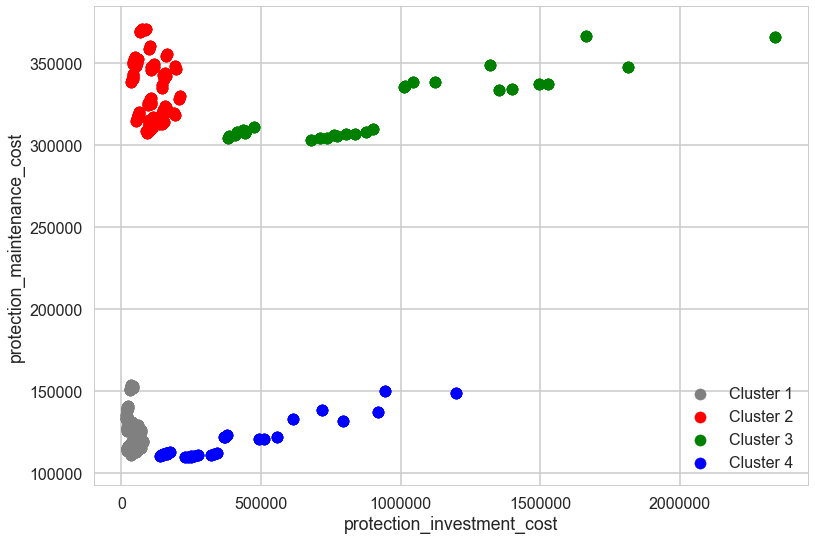

In [90]:
mycolors = ["grey","red","green","blue","pink","purple"]
for (i,subdf) in df.groupby("class"):

    plt.scatter(subdf.protection_investment_cost,subdf.protection_maintenance_cost,label="Cluster {}".format(i),c=mycolors[i-1])
plt.legend()
plt.xlabel("protection_investment_cost")
plt.ylabel("protection_maintenance_cost")

In [91]:
boxes[0].limits

,min,max,qp values
adacost_num,0.0,0.0,2.081814e-47


In [92]:
boxes[1].limits

,min,max,qp values
adacost_num,1.0,1.0,2.081814e-47


In [93]:
boxes[2].limits

,min,max,qp values
adacost_num,1.0,1.0,8.035062e-11


In [94]:
boxes[3].limits

,min,max,qp values
adacost_num,0.0,0.0,8.035062e-11


In [79]:
boxes[4].limits

IndexError: list index out of range

In [58]:
boxes[5].limits

IndexError: list index out of range

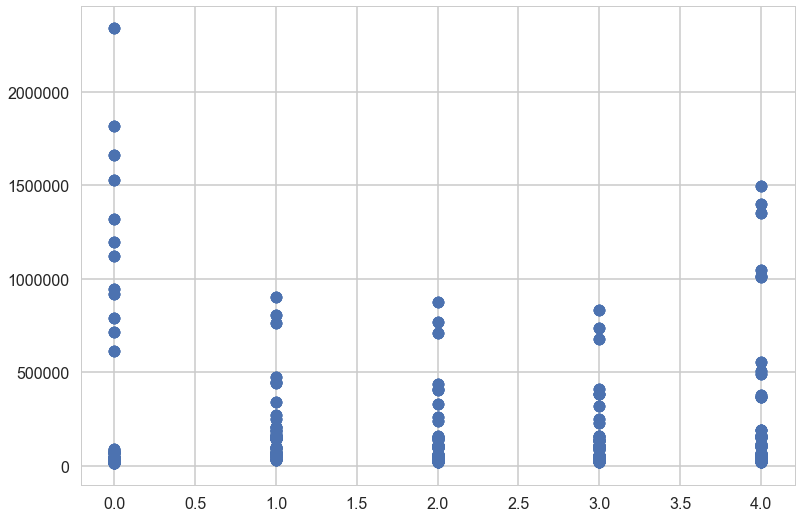

In [95]:
plt.scatter(mydata_2100.ada_num,mydata_2100.protection_investment_cost)

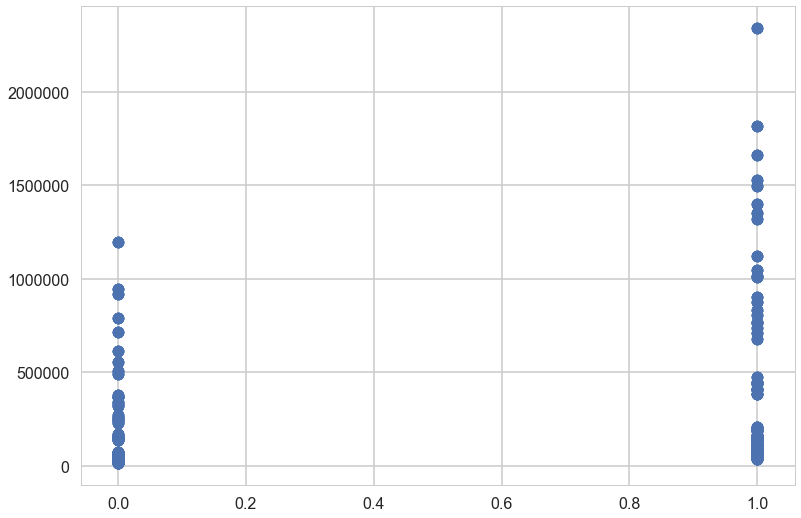

In [98]:
plt.scatter(mydata_2100.adacost_num,mydata_2100.protection_investment_cost)